# Environment Set Up

In [ ]:
# Note - Run this cell only if you are using Google Colab
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [1]:
!pip install 'tensorflow==1.14'
!pip install 'shap==0.32.1'
!pip install spacy
!python -m spacy download en_core_web_sm

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 266kB 28.7MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 27.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for shap ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 10.4MB 4.6MB/s eta 0:00:01
    100% |████████████████████████████████| 122kB 55.3MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 21.1MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 56.6MB/s eta 0:00:01
    100% |████████████████████████████████| 3.7MB 12.9MB/s ta 0:00:01
You are using pip version 10

In [2]:
from datetime import date

import collections 
import itertools
import re
import os
import pickle
import json
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import shap
import spacy
import en_core_web_sm

from keras import layers
from keras.layers import LSTM, Embedding, Dense
from keras.models import Sequential

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


# Read in and Process Text

In [49]:
path = 'Data'
fname = 'amazon_reviews_us_Musical_Instruments_v1_00.tsv'

os.path.join(path, fname)
df = pd.read_csv(os.path.join(path, fname), sep = '\t', error_bad_lines = False, warn_bad_lines = True)

In [4]:
# Find the products with less than 100 reviews
print("We started with {} unique ids".format(len(df['product_id'].unique())))
reviews_threshold = 100
pdist = df[['product_id', 'review_id']].groupby('product_id', as_index = False).count()
prods_to_keep = pdist[pdist['review_id'] > reviews_threshold]['product_id'].unique()

df = df[df['product_id'].isin(prods_to_keep)]
print("After cleansing we are left with {} products".format(len(df['product_id'].unique())))
print("Total dataset size is now {} rows".format(len(df)))

We started with 123284 unique ids
After cleansing we are left with 1105 products
Total dataset size is now 286055 rows


# Inference and Shap Calculation

After rebuilding the model architecture we load pre-trained weights. We then calculate shap values for a number of product reviews and save locally. 

In [5]:
embedding_dim = 100
maxlen = 200

In [6]:
def lstm_model(max_words, embedding_dim, input_length):
    
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=input_length))
    model.add(LSTM(100, return_sequences = False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model

In [7]:
# After training make inference after loading from latest checkpoint

max_words = 82279 # This should be fixed

inf_model = lstm_model(max_words, embedding_dim, maxlen)

# load weights
inf_model.load_weights("Models/weights-lstm-10.hdf5")

# Compile model (required to make predictions)
inf_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load vectors
x_train = np.load(os.path.join(path, 'x_train.npy'))
y_train = np.load(os.path.join(path, 'y_train.npy'))
ids_train = np.load(os.path.join(path, 'ids_train.npy'))
prod_ids_train = np.load(os.path.join(path, 'prod_ids_train.npy'))

x_test = np.load(os.path.join(path, 'x_test.npy'))
y_test = np.load(os.path.join(path, 'y_test.npy'))
ids_test = np.load(os.path.join(path, 'ids_test.npy'))
prod_ids_test = np.load(os.path.join(path, 'prod_ids_test.npy'))

# Load and unpickle tokenizer
with open(os.path.join(path, 'dictionary.pickle'), "rb") as f:
    tokenizer = pickle.load(f)

# Read in contractions, needed to clean up text
with open(os.path.join(path, 'contractions.pickle'), "rb") as f:
    contractions = pickle.load(f)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          8227900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 8,311,565
Trainable params: 8,311,565
Non-trainable params: 0
_________________________________________________________________



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(inf_model, x_train[:500])

In [100]:
# Find Products with more than 100 reviews, then find which of those products are in the test products

prods = df[['product_id', 'customer_id']].groupby('product_id').count().reset_index()
prods = prods[prods['product_id'].isin(prod_ids_test)]

In [101]:
for i in prods[prods['customer_id'] > 100]['product_id']:
    
    sample_id = np.random.choice(list(set(prod_ids_test)))
    print(sample_id)
    

    # Find the indices of the product reviews 
    indices_samp = [idx if i == sample_id else -1 for idx, i in enumerate(prod_ids_test)]
    samp_indices = np.array(list(filter(lambda x: x != -1, indices_samp)))

    # Fetch the ids for this product 
    samp_ids = ids_test[samp_indices]

    # Now subset the main dataframe for these reviews
    sub = df[df['review_id'].isin(samp_ids)]

    print('This is a {}'.format(sub.iloc[0]['product_title']))
    print('There is a total of {} reviews'.format(len(sub)))
    print('Average star rating is {}'.format(round(np.mean(sub['star_rating']),2)))
    
    # Check if prod has already been calculated
    files = os.listdir('Shaps')
    if sample_id in [x.split('_')[1].split('.')[0] for x in files]:
        print('already calculated')
        pass
    else:
        # Calculate Shap Values
        shap_values = explainer.shap_values(x_test[samp_indices])
        np.save('Shaps/shaps_{}.npy'.format(sample_id), shap_values)
        
        
    break

B0002FO9QY
This is a Epiphone 335 Hardshell Guitar Case,
There is a total of 111 reviews
Average star rating is 4.58
already calculated


# Super Reviews Data

We create summary reviews using pre-calculated shap values.

In [9]:
def synthetize_reviews(reviews, words_df, reviews_df, pos_sentiment):
    """Synthetize Review based on shap values

    Arguments:
      reviews: pandas df, 
          candidate reviews to look for sentences
      words_df: pandas df,
          dataframe with shaps values for 
          each word in a review
      reviews_df: pandas df,
          dataframe of reviews
      pos_sentiment: boolean 
          raw reviews dataframe
  """
    
    sentences_for_summary = []
    review_ids = []
    
    for word in reviews['word']:
        
        if pos_sentiment:
            temp = words_df[(words_df['word'] == word) & 
                      (words_df['shap'] > 0) & 
                      (words_df['star_rating'] > 3) & 
                      (words_df['review_len'] > 10)]
        else:
            temp = words_df[(words_df['word'] == word) & 
                      (words_df['shap'] < 0) & 
                      (words_df['star_rating'] <= 3) & 
                      (words_df['review_len'] > 10)]
        
        try:
            # Find Review with the highest absolute shap associated to that word
            temp = temp.sort_values(by = 'absolute_shap', ascending = False)
            ts = temp.iloc[0].samp_id

            # Extract single review
            ind_review = reviews_df[reviews_df['review_id'] == ts].iloc[0]
            ind_review = ind_review['review_body']
            review_ids.append(ts)

            # Split the selected review into sentences
            nlp = en_core_web_sm.load()
            sentences = list(nlp(ind_review).sents)

            # Split the review into sentences and take the first sentence where the word appears
            target_word_sents = []

            for sent in sentences:
                if str(sent).lower().find(word) >= 0:
                    target_word_sents.append(sent)

            # Check that the target word is long enough, otherwise take the first sentence in the review
            length_threshold = 5
            if len(str(target_word_sents[0]).split(" ")) <= 5:
                sentences_for_summary.append(sentences[0])
            else:
                sentences_for_summary.append(target_word_sents[0])


        except IndexError:
            pass
        
    return sentences_for_summary, review_ids

def benchmark_model(word_scores, sumdf, suprev, df):
    """Benchmark model to summarize reviews using a
    word frequencies algorithm

    Arguments:
      word_scores: pandas df, 
          dataframe of word scores
      sumdf: pandas df,
          dataframe with shaps values for 
          each word in a review
      suprev: pandas df,
          reference super review
      df: pandas df
          raw reviews dataframe
  """

    np.random.seed(42)

    # Positive Reviews
    pos_ = sumdf[sumdf['star_rating'] > 3]
    pos_freq = pd.DataFrame(pos_['word'].value_counts()).reset_index()
    pos_freq.columns = ['word', 'frequency']
    pos_freq = pd.merge(pos_freq, word_scores[['word', 'tag']], on = 'word', how = 'left')
    pos_freq = pos_freq[pos_freq['tag'].isin(['NOUN', 'PROPN'])
                       ].head(len(suprev[suprev['type'] == 'positives']))

    # Negative Reviews
    neg_ = sumdf[sumdf['star_rating'] <= 3]
    neg_freq = pd.DataFrame(neg_['word'].value_counts()).reset_index()
    neg_freq.columns = ['word', 'frequency']
    neg_freq = pd.merge(neg_freq, word_scores[['word', 'tag']], on = 'word', how = 'left')
    neg_freq = neg_freq[neg_freq['tag'].isin(['NOUN', 'PROPN'])
                       ].head(len(suprev[suprev['type'] == 'negatives']))

    super_review = []
    review_ids = []

    for w in pos_freq['word']:

        temp = sumdf[(sumdf['word'] == w) & 
                     (sumdf['star_rating'] > 3)]['samp_id'].sample().iloc[0]

        # Extract single review
        ind_review = df[df['review_id'] == temp].iloc[0]
        ind_review = ind_review['review_body']

        # Split the selected review into sentences
        nlp = en_core_web_sm.load()
        sentences = list(nlp(ind_review).sents)

        # Split the review into sentences and take the first sentence where the word appears
        target_word_sents = []

        for sent in sentences:
            if str(sent).lower().find(w) >= 0:
                target_word_sents.append(sent)

        super_review.append(target_word_sents[0])
        review_ids.append(temp)


    for w in neg_freq['word']:

        temp = sumdf[(sumdf['word'] == w) & 
                     (sumdf['star_rating'] <= 3)]['samp_id'].sample().iloc[0]

        # Extract single review
        ind_review = df[df['review_id'] == temp].iloc[0]
        ind_review = ind_review['review_body']

        # Split the selected review into sentences
        nlp = en_core_web_sm.load()
        sentences = list(nlp(ind_review).sents)

        # Split the review into sentences and take the first sentence where the word appears
        target_word_sents = []

        for sent in sentences:
            if str(sent).lower().find(w) >= 0:
                target_word_sents.append(sent)

        super_review.append(target_word_sents[0])
        review_ids.append(temp)
        
    return super_review, review_ids

In [11]:
# Calculate super reviews using pre-calculated shap values

super_review_dfs = []
evals = []
prod_ids = []
n_words = 10

i = 0

for sample_file in os.listdir('Shaps'):

    print(sample_file)
    i += 1
    print(i)

    # Find product id
    sample_id = sample_file.split('_')[1].split('.')[0]
    prod_ids.append(sample_id)

    # Find the indices of the product reviews
    indices_samp = [idx if i == sample_id else -1 for idx, i in enumerate(prod_ids_test)]
    samp_indices = np.array(list(filter(lambda x: x != -1, indices_samp)))
    samp_ids = ids_test[samp_indices]

    # Subset the main dataframe for these reviews
    sub = df[df['review_id'].isin(samp_ids)]

    print('This is a {}'.format(sub.iloc[0]['product_title']))
    print('There is a total of {} reviews'.format(len(sub)))
    print('Average star rating is {}'.format(round(np.mean(sub['star_rating']),2)))

    # Load shap values
    shap_values = np.load(os.path.join('Shaps', sample_file))

    #----------------------------------------------------------------#
    # Create Dataframe at word and review level                      #
    #----------------------------------------------------------------#

    # Crea a daframe of shaps associated to each word
    flat_shap = np.ravel(shap_values)
    flat_word_idx = np.ravel(x_test[samp_indices])
    flat_ids = np.ravel([np.repeat(x, maxlen) for x in samp_ids])

    sumdf = pd.DataFrame({'shap': flat_shap,
                          'absolute_shap': np.abs(flat_shap),
                          'word_index': flat_word_idx,
                          'samp_id': flat_ids
                          })

    # We are also interested in the weight each individual word has compared to the total shap value.
    # For this we aggregate by sample ID and sum the total shap
    totshap = sumdf[['absolute_shap', 'samp_id']].groupby('samp_id').sum().reset_index()
    totshap.rename(columns = {'absolute_shap': 'tot_abs_shap'}, inplace = True)

    sumdf = pd.merge(sumdf, totshap, on = 'samp_id', how = 'left')
    sumdf['relative_abs_shap'] = sumdf['absolute_shap']/sumdf['tot_abs_shap']

    # Do the same to find the length of a sequence
    sumdf['is_word'] = sumdf['word_index']/sumdf['word_index']
    lens = sumdf[['samp_id', 'is_word']].groupby('samp_id').sum().reset_index()
    lens.rename(columns = {'is_word': 'review_len'}, inplace = True)
    sumdf = pd.merge(sumdf, lens, on = 'samp_id', how = 'left')

    # Remove 0 word index
    sumdf = sumdf[sumdf['word_index'] != 0]
    print("After removing NA we are left with {} words".format(len(sumdf)))

    # Find the word associated to each word index
    sumdf['word'] = [tokenizer.index_word[x] for x in sumdf['word_index']]

    # Create a feature which tell us if shap value is positive or negative
    sumdf['pos_shap'] = sumdf['shap'].apply(lambda x: 1 if x > 0 else 0)

    # Join star rating and helpful votes, which will be useful further ahead
    sumdf = pd.merge(sumdf, 
             df[['review_id', 'star_rating', 'helpful_votes']].rename(columns = {'review_id': 'samp_id'}),
             on = 'samp_id',
             how = 'left')

    #----------------------------------------------------------------#
    # Create Word Level DataFrame                                    #
    #----------------------------------------------------------------#

    # For each word find the average relative score. This will help finding the heavy weight words
    cols = ['word', 'relative_abs_shap', 'pos_shap']
    word_scores = sumdf[cols].groupby('word').agg({'relative_abs_shap': [np.mean, len],
                                                   'pos_shap': np.sum})
    word_scores = word_scores.reset_index()
    word_scores.columns = ['word', 'mean_relative_abs_shap', 'frequency', 'frequency_pos_shap']

    # We assign a score to each word, weighting by the log of the word frequency
    word_scores['score'] = word_scores['mean_relative_abs_shap'] * np.log(word_scores['frequency'])
    word_scores['score'] = word_scores['mean_relative_abs_shap'] * word_scores['frequency']

    # We find the ratio of word associated with a positive score (positive sentiment) on total word freq
    word_scores['pos_sentiment_score'] = word_scores['frequency_pos_shap'] / word_scores['frequency']
    word_scores = word_scores.sort_values(by = 'score', ascending = False)

    # Using nltk assign a tag to each word 
    nlp = en_core_web_sm.load()
    word_scores['tag'] = [[token.pos_ for token in nlp(x)][0] for x in word_scores['word']]

    #----------------------------------------------------------------#
    # Find Top n positive sentiment words and Top n negative words   #
    #----------------------------------------------------------------#

    positives = word_scores[(word_scores['pos_sentiment_score'] > 0.7) &
                        (word_scores['tag'].isin(['NOUN', 'PROPN']))
                        ].head(n_words)

    negatives = word_scores[(word_scores['pos_sentiment_score'] < 0.3) &
                        (word_scores['tag'].isin(['NOUN', 'PROPN']))
                        ].head(n_words)

    #----------------------------------------------------------------#
    # Find Top n positive sentiment words and Top n negative words   #
    #----------------------------------------------------------------#

    synth_pos = synthetize_reviews(positives, sumdf, df, pos_sentiment=True)
    synth_neg = synthetize_reviews(negatives, sumdf, df, pos_sentiment=False)

    #----------------------------------------------------------------#
    # Find Top n positive sentiment words and Top n negative words   #
    #----------------------------------------------------------------#

    pos_df = pd.DataFrame({'sentences': synth_pos[0], 'review_ids': synth_pos[1], 'type': 'positives'})
    neg_df = pd.DataFrame({'sentences': synth_neg[0], 'review_ids': synth_neg[1], 'type': 'negatives'})

    suprev = pd.concat([pos_df, neg_df])
    suprev['sentences'] = suprev['sentences'].astype('str')
    suprev.drop_duplicates(inplace = True)
    suprev['product_id'] = sample_id

    #----------------------------------------------------------------#
    # Benchmark Model                                                #
    #----------------------------------------------------------------#

    super_review, review_ids = benchmark_model(word_scores, sumdf, suprev, df)
    super_review_bench = pd.DataFrame({'sentences': super_review, 'review_ids': review_ids, 'type': 'benchmark'})
    super_review_bench['sentences'] = super_review_bench['sentences'].astype('str')
    super_review_bench.drop_duplicates(inplace = True)
    super_review_bench['product_id'] = sample_id

    #----------------------------------------------------------------#
    # Evaluation                                                     #
    #----------------------------------------------------------------#

    suprev_log_votes = np.mean(np.log1p(
        df[df['review_id'].isin(suprev['review_ids'].unique())]['total_votes']))

    naive_log_votes = np.mean(np.log1p(
        df[df['review_id'].isin(review_ids)]['total_votes']))

    print("Shap log votes: {}".format(suprev_log_votes))
    print("Naive log votes: {}".format(naive_log_votes))

    # Append Final Result
    super_review_dfs.append(pd.concat([suprev, super_review_bench]))
    evals.append((suprev_log_votes, naive_log_votes))

In [16]:
# Create a dataframe of scores, where we can compare shap and benchmark model.

evals_df =  pd.DataFrame({'shap': [x[0] for x in evals], 
              'naive':[x[1] for x in evals],
              'product_id': prod_ids
             })


evals_df = pd.merge(evals_df,
         df[['product_id', 'customer_id']].groupby('product_id').count().reset_index(),
         on = 'product_id',
         how = 'left'
        )

evals_df['delta'] = evals_df['shap'] - evals_df['naive']
evals_df = evals_df.sort_values(by = 'customer_id', ascending = False)
evals_df.columns = ['shap', 'naive', 'product_id', 'reviews', 'delta']

In [17]:
# Save Evaluation DataFrame
evals_df.to_csv('Data/evals.csv', index = False)
evals_df = pd.read_csv('Data/evals.csv')

In [18]:
# Get average log votes score for shap vs benchmark model

tot_reviews = 100

print("Shap Model Log Votes: ", np.mean(evals_df[evals_df['reviews'] > tot_reviews]['shap']))
print("Benchmark Model Log Votes: ", np.mean(evals_df[evals_df['reviews'] > tot_reviews]['naive']))

print("Shap Model Tot Reviews: ", len(evals_df[evals_df['reviews'] > tot_reviews]['shap']))
print("Shap Model Tot Reviews: ", len(evals_df[evals_df['reviews'] > tot_reviews]['naive']))

Shap Model Log Votes:  0.6784162055497084
Benchmark Model Log Votes:  0.8652754620214622
Shap Model Tot Reviews:  59
Shap Model Tot Reviews:  59


In [19]:
# Check if observed mean log votes difference is statistically significant

from scipy.stats import ttest_ind

ttest_ind(evals_df[evals_df['reviews'] > tot_reviews]['shap'], 
          evals_df[evals_df['reviews'] > tot_reviews]['naive'])

Ttest_indResult(statistic=-2.6828477561316464, pvalue=0.00836641994078426)

(-1, 0.7088230988097073)

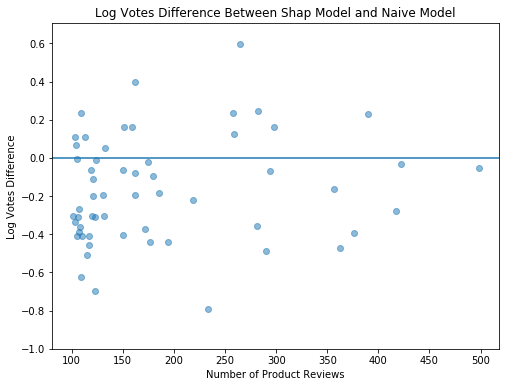

In [20]:
# Plot how the delta in score between the two models relates to number of reviews

plt.figure(figsize = (8, 6))

plt.scatter(evals_df[evals_df['reviews'] < 700]['reviews'], 
            evals_df[evals_df['reviews'] < 700]['delta'], alpha = 0.5)
plt.axhline(0)
plt.xlabel('Number of Product Reviews')
plt.ylabel('Log Votes Difference')
plt.title('Log Votes Difference Between Shap Model and Naive Model')
plt.ylim(-1)

In [21]:
# Create Dataset of Super Reviews and save

final_reviews_set = pd.concat(super_review_dfs)
final_reviews_set.to_csv('Data/super_reviews.csv', index = False)


In [48]:
# Print one sample positive review

sample_prod = final_reviews_set['product_id'].sample().iloc[0]
sample_prod = 'B0090XX0MS'

print(df[df['product_id'] == sample_prod]['product_title'].iloc[0])
print("------")

revs = final_reviews_set[final_reviews_set['product_id'] == sample_prod]
for i in revs[revs['type'] == 'positives']['sentences']:
    print(i)

TASCAM DR-05EB Portable Digital Recorder
------
Great Thing, Good Size, Great Microphone Response
But when I use 8G and 16G card to expand the memory, it shows also 2G.
Decent recording quality.
The price was big money to me
The audio quality is good and the headphones are decent.
I had to get help for that, but  would  absolutely recommend for singers and musicians.
Works great for the price point with a true stereo recording!
Great small audio recorder, Using it for capturing audio on the weddings.
Took itnout to test it right away and fell in love with the sound quality it was giving me.


In [40]:
# Print one sample negative review

for i in revs[revs['type'] == 'negatives']['sentences']:
    print(i)

we have to return it . . .
I play guitar right next to the mic
Awful playback quality.
There's a tremendous amount of warble, scratchiness, static, distortion, and generally awful noise quality.
It sounds good at first and then starts to get all scratchy.


In [41]:
# Print one sample benchmark review

for i in revs[revs['type'] == 'benchmark']['sentences']:
    print(i)

I intend to use the recordings in video I was shooting.
I use it to record rehearsals and to practice with.
Great handy recorder with excellent features and ease of handling.
This is a high quality digital recorder perfect for field recordings, live music shows, sound effects and any situation requiring high fidelity sound recording.  
Sound quality is excellent!
I bought this Digital recorder because of my budget.
Voice recordings from the DR-05 can easily be synced with the on-camera voice recordings in Vegas Pro 13, which is a bit of a hassle
The audio quality is good and the headphones are decent.
Most of the other recorders in this price range only give you a 1gb or nothing.
First, the price is right, the recorder has tons of &#34;bang for the buck,&#34; and the recording quality is more than acceptable, but there are several shortcomings.<br /><br />First, my unit did not arrive with the current firmware release installed.  
So if you are not familiar with this type of device, re